In [445]:
import numpy as np
import pandas as pd
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt

from scipy.interpolate import interp1d

import pandas as pd

import os


def find_gpx_files(directory_path):
    files = os.listdir(directory_path)
    gpx_files = [file for file in files if file.endswith('.gpx')]
    
    return gpx_files

def calculate_distances_vectorized(lat, lon, ele):
    # Earth's radius in feet
    R = 6371000 * 3.28084
    
    # Convert latitude and longitude from degrees to radians
    lat_rad = np.radians(lat)
    lon_rad = np.radians(lon)
    
    # Calculate differences between consecutive points
    dlat_rad = np.diff(lat_rad, prepend=lat_rad[0])
    dlon_rad = np.diff(lon_rad, prepend=lon_rad[0])
    d_ele = np.diff(ele, prepend=lon_rad[0])
    
    # Approximate mean latitude for each pair of points (use the first point of the pair)
    mean_lat_rad = lat_rad
    
    # First order approximation: distance = R * sqrt(dlat^2 + (dlon * cos(mean_lat))^2)
    distances_ft = R * np.sqrt(dlat_rad**2 + (dlon_rad * np.cos(mean_lat_rad))**2)
    
    # Add elevation
    distances_ft = np.sqrt(distances_ft**2 + d_ele**2)
    
    # The first value should be zero (starting point)
    distances_ft[0] = 0
    
    return distances_ft

def gpx_to_dataframe_from_file(file_path):
    # Parse the XML file
    tree = ET.parse(file_path)
    root = tree.getroot()
    
    # Namespace is required to correctly parse the XML
    ns = {'default': 'http://www.topografix.com/GPX/1/1'}
    
    # Extract route name
    route_name = root.find('.//default:rte/default:name', namespaces=ns).text
    
    # Extract route points
    route_points = root.findall('.//default:rtept', namespaces=ns)
    
    # Prepare data for DataFrame
    data = [{
        'lon': float(pt.attrib['lon']),
        'lat': float(pt.attrib['lat']),
        'ele': float(pt.find('default:ele', namespaces=ns).text)
    } for pt in route_points]
    
    # Convert to DataFrame
    df = pd.DataFrame(data)
    df['route_name'] = route_name
    
    df['elevation_ft'] = df['ele'] * 3.28084
    df['distance_ft'] = calculate_distances_vectorized(df['lat'], df['lon'], df['elevation_ft'])
    df['chg_elevation_ft'] = df['elevation_ft'] - df['elevation_ft'].iloc[0]
    df['dist_to_summit_miles'] = (df['distance_ft'].cumsum() - df['distance_ft'].sum())/5280.
    
    return df

def strava_gpx_to_dataframe(gpx_path, trim='right', route_name=None):
    # Parse the GPX file
    tree = ET.parse(gpx_path)
    root = tree.getroot()
    
    # GPX namespace
    ns = {'default': 'http://www.topografix.com/GPX/1/1'}
    
    # Extract track points
    trkpts = []
    for trkseg in root.findall('.//default:trkseg', ns):
        for trkpt in trkseg.findall('.//default:trkpt', ns):
            lat = float(trkpt.attrib['lat'])
            lon = float(trkpt.attrib['lon'])
            ele = float(trkpt.find('./default:ele', ns).text)
            time = trkpt.find('./default:time', ns).text
            trkpts.append([lat, lon, ele, time])
    
    # Convert to DataFrame
    df = pd.DataFrame(trkpts, columns=['lat', 'lon', 'ele', 'time'])
    
    # Convert Time from string to datetime
    df['time'] = pd.to_datetime(df['time'], infer_datetime_format=True)
    
    # remove reverse route
    max_idx = df[df['ele'] == df['ele'].max()].index[0]
    if trim == 'right':
        df = df.loc[:max_idx]
    elif trim == 'left':
        df = df.loc[max_idx:].iloc[::-1]
        df.index = range(len(df))
    elif trim is not None:
        df = df.loc[:trim]
    
    
    df['elevation_ft'] = df['ele'] * 3.28084
    df['distance_ft'] = calculate_distances_vectorized(df['lat'], df['lon'], df['elevation_ft'])
    df['chg_elevation_ft'] = df['elevation_ft'] - df['elevation_ft'].iloc[0]
    df['dist_to_summit_miles'] = (df['distance_ft'].cumsum() - df['distance_ft'].sum())/5280.
    
    if route_name is not None:
        df['route_name'] = route_name
    
    return df

## Load All GPX Files available, process data

In [446]:
gpx_files = find_gpx_files('data/')
approach_routes = {
    'Challenger Point - North Slope': 'data/approaches/will0_route.gpx',
    'Kit Carson Peak - Via Challenger Point': 'data/approaches/will0_route.gpx',

    'Little Bear Peak - West Ridge and Hourglass': 'data/approaches/como0_route.gpx',
    'Ellingwood Point - South Face': 'data/approaches/como0_route.gpx',
    
    'Mt. Wilson - North Slopes': 'data/approaches/nava0_route.gpx',
    'El Diente Peak - North Slopes': 'data/approaches/nava0_route.gpx',

    'North Eolus - South Ridge': 'data/approaches/chib1_route.gpx',
    'Mt. Eolus - Northeast Ridge': 'data/approaches/chib1_route.gpx',
    'Windom Peak - West Ridge': 'data/approaches/chib1_route.gpx',
    'Sunlight Peak - South Face': 'data/approaches/chib1_route.gpx',
    
    'Tabeguache Peak - Via Mt. Shavano': 'data/shav1_route.gpx',
}

In [447]:
all_data = []
for gf in gpx_files:
    print(f"\t >> {gf}")
    try:
        summit = gpx_to_dataframe_from_file(f'data/{gf}')
        route_name = summit['route_name'].max()
        if route_name in approach_routes.keys():
            print(f"\t\t>> Augmenting {route_name}")
            summit = stitch_approach(summit, approach_routes[route_name])
        all_data.append(summit)
    except AttributeError:
        print("\t\t>> ERROR :(")

	 >> elbe1_route.gpx
	 >> wils1_route.gpx
	 >> cule1_route.gpx
	 >> oxfo2_route.gpx
	 >> cast1_route.gpx
	 >> mass1_route.gpx
	 >> lapl1_route.gpx
	 >> lind1_route.gpx
	 >> holy1_route.gpx
	 >> prin1_route.gpx
	 >> wind1_route.gpx
		>> Augmenting Windom Peak - West Ridge
	 >> huro1_route.gpx
	 >> eolu3_route.gpx
		>> Augmenting Mt. Eolus - Northeast Ridge
	 >> linc1_route.gpx
	 >> humb1_route.gpx
	 >> demo1_route.gpx
	 >> eldi3_route.gpx
		>> Augmenting El Diente Peak - North Slopes
	 >> harv1_route.gpx
	 >> bros2_route.gpx
	 >> sunl2_route.gpx
		>> Augmenting Sunlight Peak - South Face
	 >> quan1_route.gpx
	 >> nmar2_route.gpx
	 >> miss1_route.gpx
	 >> belf1_route.gpx
	 >> shav1_route.gpx
	 >> evan2_route.gpx
	 >> capi1_route.gpx
	 >> litt6_route.gpx
		>> Augmenting Little Bear Peak - West Ridge and Hourglass
	 >> blan1_route.gpx
		>> ERROR :(
	 >> elli2_route.gpx
		>> Augmenting Ellingwood Point - South Face
	 >> sher1_route.gpx
	 >> kitc2_route.gpx
		>> Augmenting Kit Carson Peak - 

In [448]:
# Add Uncompahgre
all_data.append(strava_gpx_to_dataframe(
    'data/strava/Uncompahgre.gpx',
    trim='right',
    route_name='Uncompahgre Peak - South Ridge'))

# Add Blanca
all_data.append(strava_gpx_to_dataframe(
    'data/strava/Blanca_Ellingwood_Traverse.gpx',
    trim='left',
    route_name='Blanca Peak - Northwest Ridge'))

# Add Redcloud
all_data.append(strava_gpx_to_dataframe(
    'data/strava/Redcloud_Sunshine.gpx',
    trim='right',
    route_name='Redcloud Peak - Northeast Ridge'))

# Add Sunshine
all_data.append(strava_gpx_to_dataframe(
    'data/strava/Redcloud_Sunshine.gpx',
    trim=14877,
    route_name='Sunshine Peak - Via Redcloud Peak'))

In [449]:
peak_elevations = pd.read_csv('clean_data/peak_elevations.csv')
peak_elevations = {n: e for n,e in peak_elevations[['name', 'elevation']].to_records(index=False)}

def correct_elevation(df):

    if 'raw_elevation_ft' not in df.columns:
        df['raw_elevation_ft'] = df['elevation_ft'].copy()
    
    peak_name = df['route_name'].max().split(' - ')[0]
    max_ele, min_ele = df['raw_elevation_ft'].max(), df['raw_elevation_ft'].min()
    true_ele = peak_elevations[peak_name]
    
    m = (true_ele - min_ele) / (max_ele - min_ele)
    df['elevation_ft'] = m * (df['raw_elevation_ft'] - min_ele) + min_ele

In [450]:
for df in all_data:
    correct_elevation(df)

## Visualize

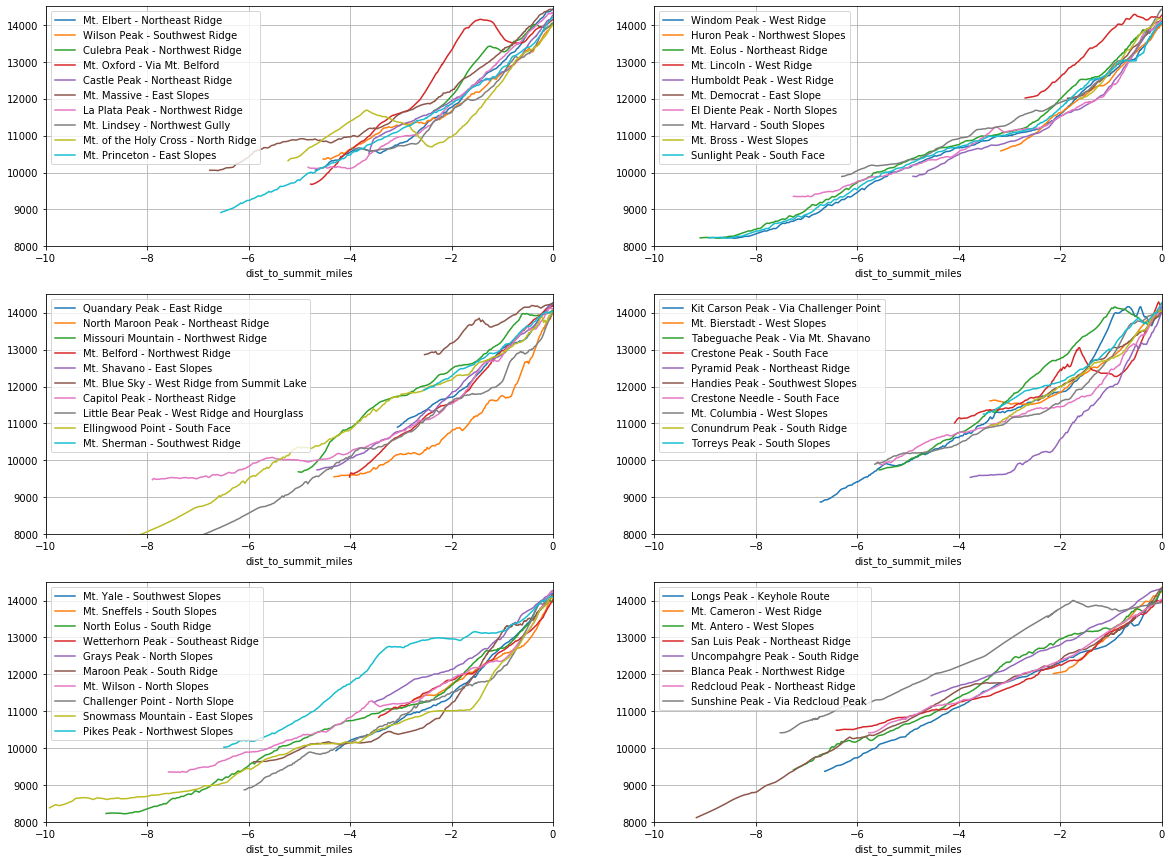

In [451]:
fig, axes = plt.subplots(3, 2)
fig.set_size_inches(20, 15)

peaks_per_ax = 10

for shift, ax in enumerate(axes.ravel()):
    
    for i in range(peaks_per_ax):
        
        idx = i + shift*peaks_per_ax
        if idx >= len(all_data):
            break
        df = all_data[idx]
        df.set_index('dist_to_summit_miles')['elevation_ft'].sort_index().plot(
            grid=True, label=df['route_name'].iloc[0], ax=ax)

    ax.legend(loc='upper left')
    ax.set_xlim(-10, 0)
    ax.set_ylim(8000,14500)

(8000, 14500)

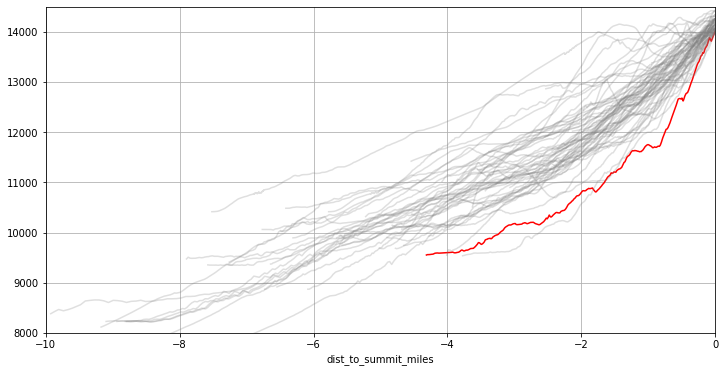

In [452]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(12, 6)

for i, df in enumerate(all_data):

    color, alpha = ('red', 1.0) if i == 21 else ('gray', 0.25)
    
    df.set_index('dist_to_summit_miles')['elevation_ft'].sort_index().plot(
        grid=True, ax=ax, color=color, alpha=alpha)
    

ax.set_xlim(-10, 0)
ax.set_ylim(8000,14500)

## Standardize X axis

In [453]:
def resample_dataframe(df, x_col, y_col, x_new):
    # Ensure the DataFrame is sorted by 'x'
    df_sorted = df[[x_col, y_col]].copy().sort_values(by=x_col).reset_index(drop=True)
    
    # Interpolate y values at the new x positions
    interpolator = interp1d(df_sorted[x_col], df_sorted[y_col], kind='linear', bounds_error=False)
    y_new = interpolator(x_new)
    
    return y_new

In [454]:
x_new = np.linspace(-10,0.0,1001)
norm_data = {}
for df in all_data:
    route_name = df['route_name'].iloc[0]
    y_new = resample_dataframe(df, 'dist_to_summit_miles', 'elevation_ft', x_new)
    norm_data[route_name] = pd.Series(y_new, index=x_new)
norm_data = pd.DataFrame(norm_data)
norm_data.index.name = 'dist_to_summit_miles'

## Plot Norm Data

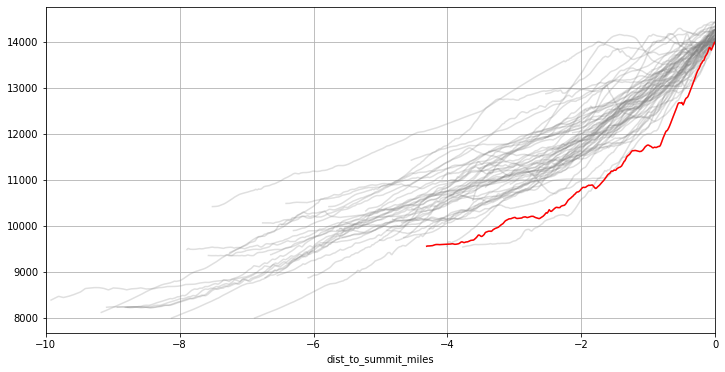

In [455]:
ax = norm_data.plot(color='gray', alpha=0.25,grid=True, figsize=(12, 6), legend=False)
norm_data['North Maroon Peak - Northeast Ridge'].plot(ax=ax, grid=True, color='red')

In [456]:
dist_resolution = pd.Series({ d['route_name'].min(): d['distance_ft'].max() 
                        for d in all_data }).astype(int)

In [457]:
resolution = pd.Series({ d['route_name'].min(): d['elevation_ft'].diff().max() 
                        for d in all_data }).astype(int)

In [458]:
max_ele_measured = pd.Series({d['route_name'].max(): d['elevation_ft'].max() for d in all_data}).sort_values()

In [459]:
max_ele_measured

Sunshine Peak - Via Redcloud Peak              14001.0
Huron Peak - Northwest Slopes                  14003.0
Mt. of the Holy Cross - North Ridge            14005.0
San Luis Peak - Northeast Ridge                14014.0
North Maroon Peak - Northeast Ridge            14014.0
Wetterhorn Peak - Southeast Ridge              14015.0
Wilson Peak - Southwest Ridge                  14017.0
Pyramid Peak - Northeast Ridge                 14018.0
Redcloud Peak - Northeast Ridge                14034.0
Mt. Sherman - Southwest Ridge                  14036.0
Little Bear Peak - West Ridge and Hourglass    14037.0
North Eolus - South Ridge                      14039.0
Ellingwood Point - South Face                  14042.0
Mt. Lindsey - Northwest Gully                  14042.0
Culebra Peak - Northwest Ridge                 14047.0
Handies Peak - Southwest Slopes                14048.0
Sunlight Peak - South Face                     14059.0
Conundrum Peak - South Ridge                   14060.0
Mt. Bierst

# Align Ranges

In [460]:
range_map = {
    'Mt. Elbert - Northeast Ridge': ('Sawatch', 'I'),
    'Wilson Peak - Southwest Ridge': ('San Juans', 'III'),
    'Culebra Peak - Northwest Ridge': ('Sangres', 'II'),
    'Mt. Oxford - Via Mt. Belford': ('Sawatch', 'II'),
    'Castle Peak - Northeast Ridge': ('Elk', 'II'),
    'Mt. Massive - East Slopes': ('Sawatch', 'II'),
    'La Plata Peak - Northwest Ridge': ('Sawatch', 'II'),
    'Mt. Lindsey - Northwest Gully': ('Sangres', 'III'),
    'Mt. of the Holy Cross - North Ridge': ('Sawatch', 'II'),
    'Mt. Princeton - East Slopes': ('Sawatch', 'II'),
    'Windom Peak - West Ridge': ('San Juans', 'II'),
    'Huron Peak - Northwest Slopes': ('Sawatch', 'II'),
    'Mt. Eolus - Northeast Ridge': ('San Juans', 'III'),
    'Mt. Lincoln - West Ridge': ('10/Mosquito', 'II'),
    'Humboldt Peak - West Ridge': ('Sangres', 'II'),
    'Mt. Democrat - East Slope': ('10/Mosquito', 'II'),
    'El Diente Peak - North Slopes': ('San Juans', 'III'),
    'Mt. Harvard - South Slopes': ('Sawatch', 'II'),
    'Mt. Bross - West Slopes': ('10/Mosquito', 'II'),
    'Sunlight Peak - South Face': ('San Juans', 'IV'),
    'Quandary Peak - East Ridge': ('10/Mosquito', 'I'),
    'North Maroon Peak - Northeast Ridge': ('Elk', 'IV'),
    'Missouri Mountain - Northwest Ridge': ('Sawatch', 'II'),
    'Mt. Belford - Northwest Ridge': ('Sawatch', 'II'),
    'Mt. Shavano - East Slopes': ('Sawatch', 'II'),
    'Mt. Blue Sky - West Ridge from Summit Lake': ('Front', 'II'),
    'Capitol Peak - Northeast Ridge': ('Elk', 'IV'),
    'Little Bear Peak - West Ridge and Hourglass': ('Sangres', 'IV'),
    'Mt. Sherman - Southwest Ridge': ('10/Mosquito', 'II'),
    'Kit Carson Peak - Via Challenger Point': ('Sangres', 'III'),
    'Mt. Bierstadt - West Slopes': ('Front', 'II'),
    'Tabeguache Peak - Via Mt. Shavano': ('Sawatch', 'II'),
    'Crestone Peak - South Face': ('Sangres', 'III'),
    'Pyramid Peak - Northeast Ridge': ('Elk', 'IV'),
    'Handies Peak - Southwest Slopes': ('San Juans', 'I'),
    'Crestone Needle - South Face': ('Sangres', 'IV'),
    'Mt. Columbia - West Slopes': ('Sawatch', 'II'),
    'Conundrum Peak - South Ridge': ('Elk', 'II'),
    'Torreys Peak - South Slopes': ('Front', 'I'),
    'Mt. Yale - Southwest Slopes': ('Sawatch', 'II'),
    'Mt. Sneffels - South Slopes': ('San Juans', 'III'),
    'North Eolus - South Ridge': ('San Juans', 'III'),
    'Wetterhorn Peak - Southeast Ridge': ('San Juans', 'III'),
    'Grays Peak - North Slopes': ('Front', 'I'),
    'Maroon Peak - South Ridge': ('Elk', 'III'),
    'Mt. Wilson - North Slopes': ('San Juans', 'IV'),
    'Challenger Point - North Slope': ('Sangres', 'II'),
    'Snowmass Mountain - East Slopes': ('Elk', 'III'),
    'Pikes Peak - Northwest Slopes': ('Front', 'II'),
    'Longs Peak - Keyhole Route': ('Front', 'III'),
    'Mt. Cameron - West Ridge': ('10/Mosquito', 'II'),
    'Mt. Antero - West Slopes': ('Sawatch', 'II'),
    'San Luis Peak - Northeast Ridge': ('San Juans', 'I'),
    'Ellingwood Point - South Face': ('Sangres', 'II'),
    'Uncompahgre Peak - South Ridge': ('San Juans', 'II'),
    'Blanca Peak - Northwest Ridge': ('Sangres', 'II'),
    'Redcloud Peak - Northeast Ridge': ('San Juans', 'II'),
    'Sunshine Peak - Via Redcloud Peak': ('San Juans', 'II')
}

In [461]:
column_names = {k: f"{k} - {c} - {r}" for k, (r,c) in range_map.items()}

## Save Normed Data

In [462]:
norm_data.rename(columns=column_names).to_pickle('clean_data/peak_profiles.pkl')
norm_data.rename(columns=column_names).to_csv('clean_data/peak_profiles.csv')
norm_data.rename(columns=column_names).to_csv('dismal-wilderness/peak_profiles.csv')

## Stitching 

In [200]:
approach = gpx_to_dataframe_from_file('data/approaches/will0_route.gpx')
como_approach = gpx_to_dataframe_from_file('data/approaches/como0_route.gpx')
chi_approach = gpx_to_dataframe_from_file('data/approaches/chib1_route.gpx')
nav_approach = gpx_to_dataframe_from_file('data/approaches/nava0_route.gpx')

In [245]:
challenger = [d for d in all_data if d['route_name'].str.contains('Challenger').any()][-1]
kitt = [d for d in all_data if d['route_name'].str.contains('Challenger').any()][0]
lil_bear = [d for d in all_data if d['route_name'].str.contains('Little').any()][0]
ellingwood = [d for d in all_data if d['route_name'].str.contains('Ellingwood').any()][0]

mt_eolus = [d for d in all_data if d['route_name'].str.contains('Eolus').any()][0]
n_eolus = [d for d in all_data if d['route_name'].str.contains('Eolus').any()][1]
sunlight = [d for d in all_data if d['route_name'].str.contains('Sunlight').any()][0]
windom = [d for d in all_data if d['route_name'].str.contains('Windom').any()][0]

eldi = [d for d in all_data if d['route_name'].str.contains('El Diente').any()][0]
wilson = [d for d in all_data if d['route_name'].str.contains('Wilson').any()][1]
wilson_pk = [d for d in all_data if d['route_name'].str.contains('Wilson').any()][0]

castle = [d for d in all_data if d['route_name'].str.contains('Castle').any()][0]
conun = [d for d in all_data if d['route_name'].str.contains('Conun').any()][0]

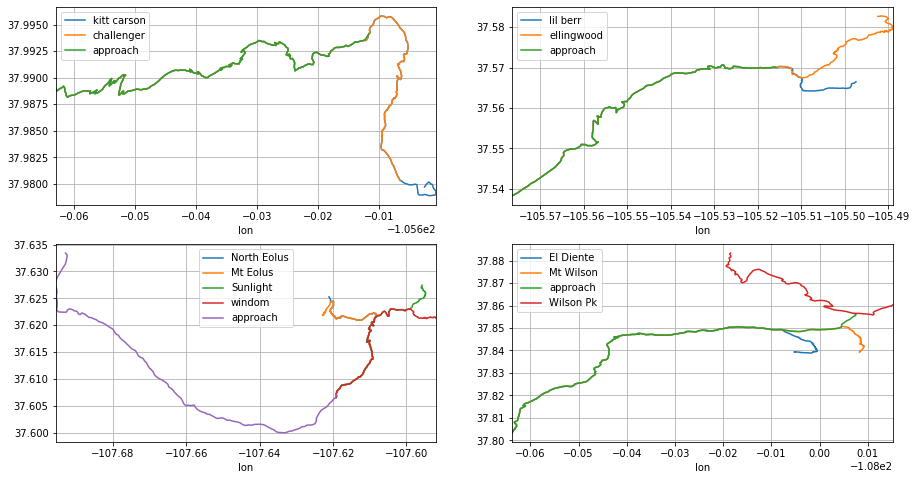

In [208]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2)
fig.set_size_inches(15, 8)

ax = kitt.plot(x='lon', y='lat', grid=True, label='kitt carson', ax=ax1)
challenger.plot(x='lon', y='lat', grid=True, label='challenger', ax=ax)
approach.plot(x='lon', y='lat', grid=True, label='approach', ax=ax)
ax.legend(loc='best')

ax = lil_bear.plot(x='lon', y='lat', grid=True, label='lil berr', ax=ax2)
ellingwood.plot(x='lon', y='lat', grid=True, label='ellingwood', ax=ax)
como_approach.plot(x='lon', y='lat', grid=True, label='approach', ax=ax)
ax.legend(loc='best')

ax = n_eolus.plot(x='lon', y='lat', grid=True, label='North Eolus', ax=ax3)
mt_eolus.plot(x='lon', y='lat', grid=True, label='Mt Eolus', ax=ax)
sunlight.plot(x='lon', y='lat', grid=True, label='Sunlight', ax=ax)
windom.plot(x='lon', y='lat', grid=True, label='windom', ax=ax)
chi_approach.plot(x='lon', y='lat', grid=True, label='approach', ax=ax)
ax.legend(loc='best')

ax = eldi.plot(x='lon', y='lat', grid=True, label='El Diente', ax=ax4)
wilson.plot(x='lon', y='lat', grid=True, label='Mt Wilson', ax=ax)
nav_approach.plot(x='lon', y='lat', grid=True, label='approach', ax=ax)
wilson_pk.plot(x='lon', y='lat', grid=True, label='Wilson Pk', ax=ax)
ax.legend(loc='best')

In [249]:
combi = gpx_to_dataframe_from_file('data/approaches/cast4_route.gpx')

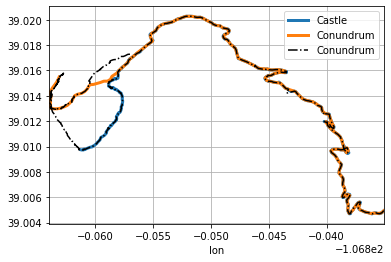

In [254]:
ax = castle.plot(x='lon', y='lat', grid=True, label='Castle', linewidth=3)
conun.plot(x='lon', y='lat', grid=True, label='Conundrum', ax=ax, linewidth=3)
combi.plot(x='lon', y='lat', grid=True, label='Conundrum', ax=ax, linestyle='-.', color='k')

In [116]:
# Keep approach up to where it merges w/ route

def stitch_approach(summit, approach_file_path):

    approach = gpx_to_dataframe_from_file(approach_file_path)
    
    # Keep approach route only up to its closest approach to summit route's start
    summit_start = summit.iloc[0][['lon', 'lat']]
    dist_start = np.sqrt(((approach[['lon', 'lat']] - summit_start)**2).sum(axis=1))
    start_idx = dist_start[dist_start == dist_start.min()].index[0]
    clean_approach = approach.loc[:start_idx].copy()
    
    # Stitch together, and ammend derived fields
    augmented_route = pd.concat([clean_approach, summit])
    augmented_route['route_name'] = summit['route_name'].max()
    augmented_route['dist_to_summit_miles'] = (
        augmented_route['distance_ft'].fillna(0).cumsum() 
        - augmented_route['distance_ft'].fillna(0).sum())/5280.
    augmented_route['chg_elevation_ft'] = (
        augmented_route['elevation_ft'] 
        - augmented_route['elevation_ft'].iloc[0]
    )
    
    return augmented_route

In [117]:
augmented_route = stitch_approach(challenger, 'data/approaches/will0_route.gpx')

In [156]:
ellingwood['route_name']

0      Ellingwood Point - South Face
1      Ellingwood Point - South Face
2      Ellingwood Point - South Face
3      Ellingwood Point - South Face
4      Ellingwood Point - South Face
                   ...              
272    Ellingwood Point - South Face
273    Ellingwood Point - South Face
274    Ellingwood Point - South Face
275    Ellingwood Point - South Face
276    Ellingwood Point - South Face
Name: route_name, Length: 277, dtype: object

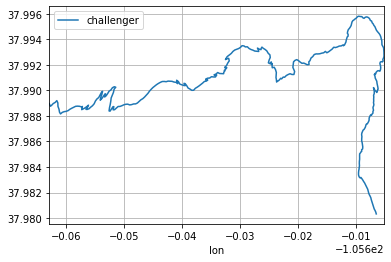

In [118]:
augmented_route.plot(x='lon', y='lat', grid=True, label='challenger')

In [119]:
augmented_route = stitch_approach(kitt, 'data/approaches/will0_route.gpx')

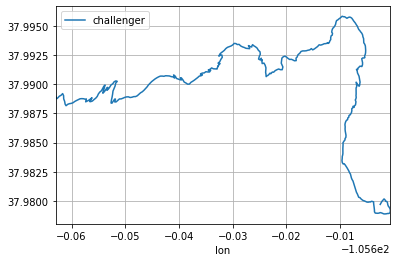

In [120]:
augmented_route.plot(x='lon', y='lat', grid=True, label='challenger')

## Strava

In [342]:
uncom = strava_gpx_to_dataframe('data/strava/Uncompahgre.gpx')
blanca = strava_gpx_to_dataframe('data/strava/Blanca_Ellingwood_Traverse.gpx', trim='left')
redcloud = strava_gpx_to_dataframe('data/strava/Redcloud_Sunshine.gpx')
sunshine = strava_gpx_to_dataframe('data/strava/Redcloud_Sunshine.gpx', trim=14877)

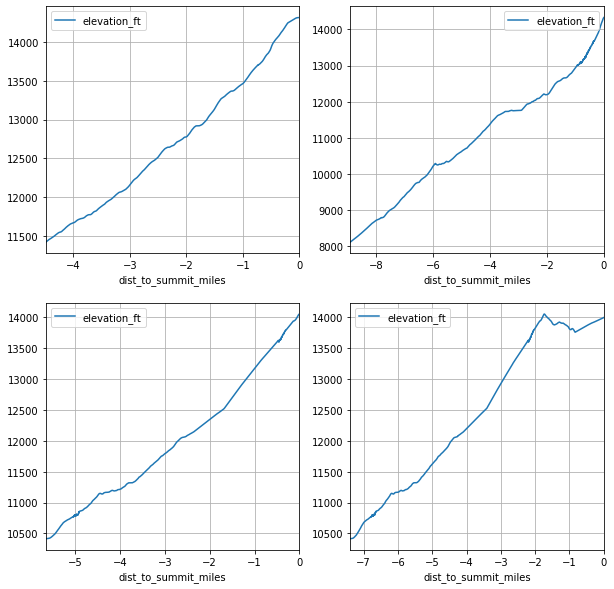

In [344]:
fig, ((ax1, ax2),(ax3, ax4)) = plt.subplots(2, 2)
fig.set_size_inches(10, 10)

uncom.plot('dist_to_summit_miles', 'elevation_ft', grid=True, ax=ax1)
blanca.plot('dist_to_summit_miles', 'elevation_ft', grid=True, ax=ax2)
redcloud.plot('dist_to_summit_miles', 'elevation_ft', grid=True, ax=ax3)
sunshine.plot('dist_to_summit_miles', 'elevation_ft', grid=True, ax=ax4)

In [340]:
sunshine = strava_gpx_to_dataframe('data/strava/Redcloud_Sunshine.gpx', trim=14877)

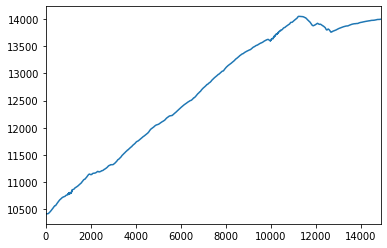

In [341]:
tmp = sunshine['elevation_ft'].plot()

In [362]:
south_colony = strava_gpx_to_dataframe('data/strava/crestone_needle_via_ellingwood_arete.gpx', trim='left')

In [367]:
needle = [d for d in all_data if d['route_name'].str.contains('Needle').any()][0]
humboldt = [d for d in all_data if d['route_name'].str.contains('Humbol').any()][0]

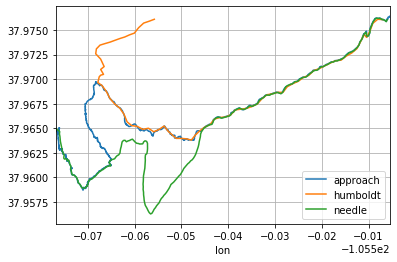

In [374]:
ax = south_colony.plot(x='lon', y='lat', grid=True, label='approach')
humboldt.plot(x='lon', y='lat', grid=True, label='humboldt', ax=ax)
needle.plot(x='lon', y='lat', grid=True, label='needle', ax=ax)

ax.legend(loc='best')

## Peak Elevations

In [412]:
peak_elevations = pd.read_csv('clean_data/peak_elevations.csv')
peak_elevations = {n: e for n,e in peak_elevations[['name', 'elevation']].to_records(index=False)}

In [413]:
tmp = all_data[0]

In [411]:
def correct_elevation(df):

    if 'raw_elevation_ft' not in df.columns:
        df['raw_elevation_ft'] = df['elevation_ft'].copy()
    
    peak_name = df['route_name'].max().split(' - ')[0]
    max_ele, min_ele = df['raw_elevation_ft'].max(), df['raw_elevation_ft'].min()
    true_ele = peak_elevations[peak_name]
    
    m = (true_ele - min_ele) / (max_ele - min_ele)
    df['elevation_ft'] = m * (df['raw_elevation_ft'] - min_ele) + min_ele

In [414]:
correct_elevation(tmp)

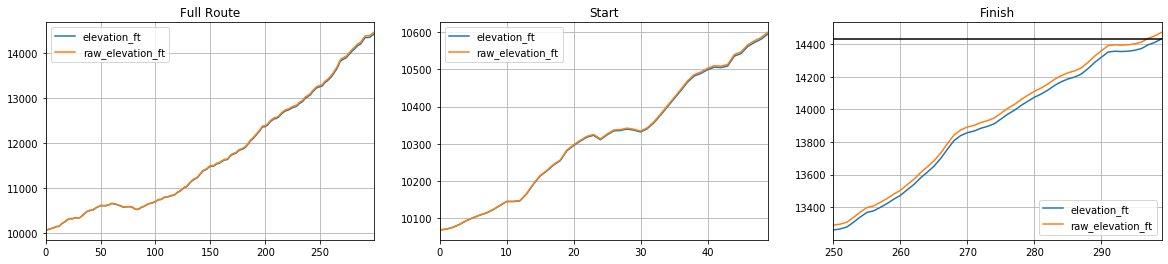

In [415]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
fig.set_size_inches(20, 4)

tmp[['elevation_ft', 'raw_elevation_ft']].plot(ax=ax1, title='Full Route', grid=True)
tmp[['elevation_ft', 'raw_elevation_ft']].iloc[:50].plot(ax=ax2, title='Start', grid=True)
tmp[['elevation_ft', 'raw_elevation_ft']].iloc[-50:].plot(ax=ax3, title='Finish', grid=True)
ax3.axhline(true_ele, color='k')

In [464]:
norm_data.diff(24).max().sort_values(ascending=False)

North Maroon Peak - Northeast Ridge            814.079402
Crestone Peak - South Face                     780.251959
Little Bear Peak - West Ridge and Hourglass    755.901461
Kit Carson Peak - Via Challenger Point         737.891237
Challenger Point - North Slope                 716.292438
Pyramid Peak - Northeast Ridge                 714.611486
Mt. Sneffels - South Slopes                    703.891785
Sunlight Peak - South Face                     649.127283
Mt. Wilson - North Slopes                      644.842997
Mt. Columbia - West Slopes                     634.846732
El Diente Peak - North Slopes                  634.647040
Longs Peak - Keyhole Route                     622.240738
Snowmass Mountain - East Slopes                622.041013
Crestone Needle - South Face                   604.815346
Maroon Peak - South Ridge                      561.144162
Capitol Peak - Northeast Ridge                 558.448088
Mt. Yale - Southwest Slopes                    557.678084
Mt. Harvard - 

In [465]:
norm_data.diff(12).max().sort_values(ascending=False)

North Maroon Peak - Northeast Ridge            472.264341
Little Bear Peak - West Ridge and Hourglass    442.099825
Crestone Peak - South Face                     425.798708
Pyramid Peak - Northeast Ridge                 416.669393
Sunlight Peak - South Face                     413.408391
Kit Carson Peak - Via Challenger Point         403.550011
Challenger Point - North Slope                 399.873063
Castle Peak - Northeast Ridge                  391.042527
Mt. Sneffels - South Slopes                    375.614631
Crestone Needle - South Face                   364.938760
El Diente Peak - North Slopes                  349.747276
Longs Peak - Keyhole Route                     343.140821
Snowmass Mountain - East Slopes                337.722805
Mt. Wilson - North Slopes                      336.477635
Mt. Lindsey - Northwest Gully                  326.458300
Conundrum Peak - South Ridge                   324.720833
Mt. Yale - Southwest Slopes                    321.815033
Mt. Columbia -